# Exercise 3: Image generation

In [2]:
from torch import nn
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Uncomment the device you want to use
device = 'cpu'
# device = 'cuda'
# device = 'mps'

## Data loading

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_classification_dataset = MNIST(
    "./data", download=True, transform=transform, train=True
)
train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=64, shuffle=True
)

validation_classification_dataset = MNIST(
    "./data", download=True, transform=transform, train=False
)
validation_classification_loader = DataLoader(
    validation_classification_dataset, batch_size=64, shuffle=False
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 880893.37it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 215584.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1147099.28it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3998012.33it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Base model definition

In [4]:
class GenerationModel(nn.Module):
    def __init__(self, hidden_size=8, channels=1, size=(28, 28)):
        super(GenerationModel, self).__init__()
        self.hidden_size = hidden_size
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * size[0] * size[1], 256),
            nn.SiLU(),
            nn.Linear(256, hidden_size),
            nn.SiLU(),
        )
        self.mu = nn.Linear(hidden_size, hidden_size)
        self.logvar = nn.Linear(hidden_size, hidden_size)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.SiLU(),
            nn.Linear(256, channels * size[0] * size[1]),
            nn.Sigmoid(),
            nn.Unflatten(1, (channels, size[0], size[1])),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### PSNR metric

In [5]:
# TODO: Reuse this function from exercise 2
import torch.nn.functional as F

def psnr(y_pred, y):
    mse = F.mse_loss(y_pred, y)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0  # Since the images are normalized to [0, 1]
    psnr_value = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr_value.item()

### SSIM metric

In [7]:
# TODO: Reuse this function from exercise 2
import torch
import torch.nn.functional as F
import numpy as np

def gaussian(window_size, sigma):
    gauss = torch.tensor([np.exp(-(x - window_size // 2) ** 2 / (2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(y_pred, y, window_size=11, C1=np.square(0.01), C2=np.square(0.032)):
    channel = y.size(1)
    window = create_window(window_size, channel).to(y.device)
    
    mu1 = F.conv2d(y_pred, window, padding=window_size//2, groups=channel)
    mu2 = F.conv2d(y, window, padding=window_size//2, groups=channel)
    
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = F.conv2d(y_pred * y_pred, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(y * y, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(y_pred * y, window, padding=window_size//2, groups=channel) - mu1_mu2
    
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

## Base model trainer

In [8]:
def ssim_and_psnr(y_pred, y):
    return ssim(y_pred, y), psnr(y_pred, y)


def loss_function(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum((1 + logvar - mu.pow(2) - logvar.exp()))
    return MSE + KLD

def trainer(model, epochs, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            y_pred, mu, logvar = model(x)
            loss = loss_function(y_pred, x, mu, logvar)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}, Loss: {total_loss/len(train_loader)}")

        model.eval()
        with torch.no_grad():
            psnr_metrics, ssim_metrics = 0, 0
            for i, (x, _) in enumerate(val_loader):
                x = x.to(device)
                y_pred, _, _ = model(x)
                metrics = ssim_and_psnr(y_pred, x)
                ssim_metrics += metrics[0]
                psnr_metrics += metrics[1]
            print(
                f"Epoch: {epoch}, SSIM: {ssim_metrics/len(val_loader)}, PSNR: {psnr_metrics/len(val_loader)}"
            )

In [9]:
model = GenerationModel().to(device)
trainer(model, 30, train_classification_loader, validation_classification_loader)

/home/kaplank/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0, Loss: 3255.569258504839
Epoch: 0, SSIM: 0.44274988770484924, PSNR: 12.920056130476059
Epoch: 1, Loss: 2711.4349151806537
Epoch: 1, SSIM: 0.5309770107269287, PSNR: 13.390639037842963
Epoch: 2, Loss: 2522.6943656091753
Epoch: 2, SSIM: 0.5882514119148254, PSNR: 13.787783580221188
Epoch: 3, Loss: 2415.8936836551757
Epoch: 3, SSIM: 0.614273190498352, PSNR: 14.01252846201514
Epoch: 4, Loss: 2354.0123484922624
Epoch: 4, SSIM: 0.6293957829475403, PSNR: 14.16926547372417
Epoch: 5, Loss: 2315.8722398835203
Epoch: 5, SSIM: 0.6379048228263855, PSNR: 14.218764456973714
Epoch: 6, Loss: 2289.724544175398
Epoch: 6, SSIM: 0.6475529670715332, PSNR: 14.309680835456605
Epoch: 7, Loss: 2264.881773340677
Epoch: 7, SSIM: 0.6571800708770752, PSNR: 14.379769464966598
Epoch: 8, Loss: 2243.0367660685133
Epoch: 8, SSIM: 0.6613221764564514, PSNR: 14.435572344786042
Epoch: 9, Loss: 2221.2612767982077
Epoch: 9, SSIM: 0.6692090630531311, PSNR: 14.485701160066446
Epoch: 10, Loss: 2203.8858714154535
Epoch: 10

## Conditional model definition 

In [10]:
class ConditionalGenerationModel(GenerationModel):
    def __init__(self, hidden_size=8, channels=1, size=(28, 28), n_classes=10):
        super(ConditionalGenerationModel, self).__init__(hidden_size, channels, size)
        self.label_embedding = nn.Embedding(n_classes, hidden_size)

    def forward(self, x, labels):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        label_embedding = self.label_embedding(labels)
        z += label_embedding
        return self.decode(z), mu, logvar
    

def generate_images(model, digit, n_images=5):
    model.eval()
    with torch.no_grad():
        labels = torch.tensor([digit] * n_images).to(device)
        z = torch.randn(n_images, model.hidden_size).to(device)
        z += model.label_embedding(labels)
        generated_images = model.decode(z).cpu()
    return generated_images

## Conditional model trainer

In [11]:
def conditional_trainer(model, epochs, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i, (x, label) in enumerate(train_loader):
            x = x.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            y_pred, mu, logvar = model(x, label)
            loss = loss_function(y_pred, x, mu, logvar)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}, Loss: {total_loss/len(train_loader)}")

        model.eval()
        with torch.no_grad():
            psnr_metrics, ssim_metrics = 0, 0
            for i, (x, label) in enumerate(val_loader):
                x = x.to(device)
                label = label.to(device)
                y_pred, _, _ = model(x, label)
                metrics = ssim_and_psnr(y_pred, x)
                ssim_metrics += metrics[0]
                psnr_metrics += metrics[1]
            print(
                f"Epoch: {epoch}, SSIM: {ssim_metrics/len(val_loader)}, PSNR: {psnr_metrics/len(val_loader)}"
            )

Epoch: 0, Loss: 2850.185203828791
Epoch: 0, SSIM: 0.5745362043380737, PSNR: 13.944710840844804
Epoch: 1, Loss: 2249.7979299061335
Epoch: 1, SSIM: 0.6419559717178345, PSNR: 14.466820893014313
Epoch: 2, Loss: 2141.2476206700176
Epoch: 2, SSIM: 0.6664895415306091, PSNR: 14.709981559947797
Epoch: 3, Loss: 2081.0248735830473
Epoch: 3, SSIM: 0.6848292946815491, PSNR: 14.815937777233732
Epoch: 4, Loss: 2037.3373026573327
Epoch: 4, SSIM: 0.6881047487258911, PSNR: 14.920872821929349
Epoch: 5, Loss: 2002.1061932334005
Epoch: 5, SSIM: 0.698045551776886, PSNR: 15.0517999685494
Epoch: 6, Loss: 1971.928538633562
Epoch: 6, SSIM: 0.7060126662254333, PSNR: 15.130541430916756
Epoch: 7, Loss: 1946.6310729329773
Epoch: 7, SSIM: 0.7204355001449585, PSNR: 15.241804803252979
Epoch: 8, Loss: 1923.3740944933536
Epoch: 8, SSIM: 0.7204921245574951, PSNR: 15.252700854258933
Epoch: 9, Loss: 1904.8366580792328
Epoch: 9, SSIM: 0.7252445816993713, PSNR: 15.349177974044897
Epoch: 10, Loss: 1890.5990993605494
Epoch: 10

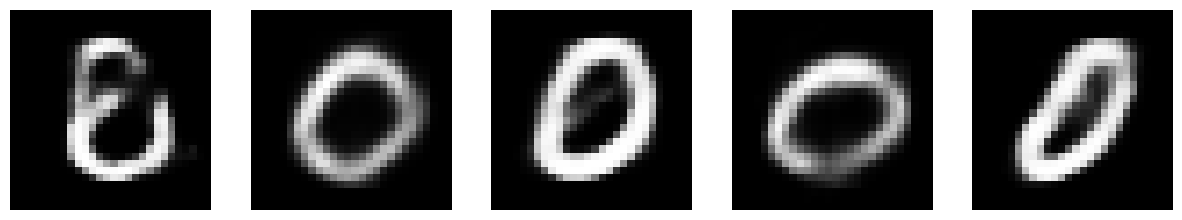

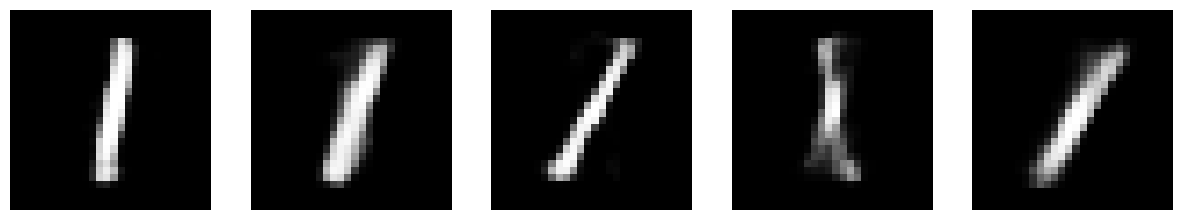

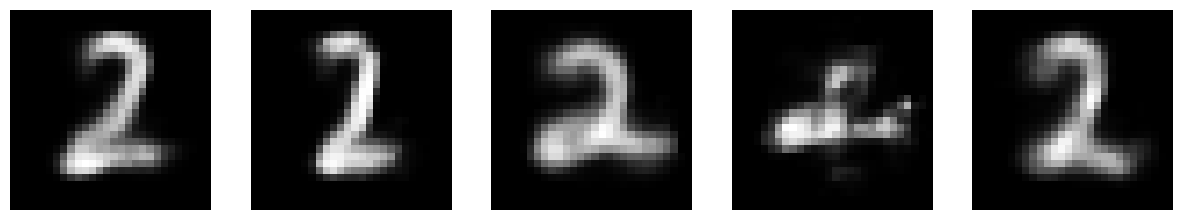

In [12]:
conditional_model = ConditionalGenerationModel(n_classes=10).to(device)
conditional_trainer(
    conditional_model, 30, train_classification_loader, validation_classification_loader
)


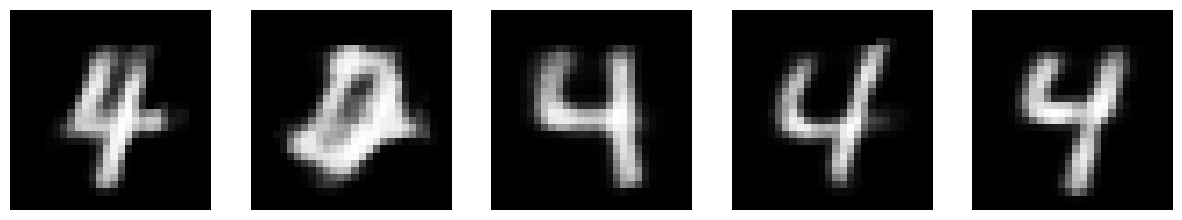

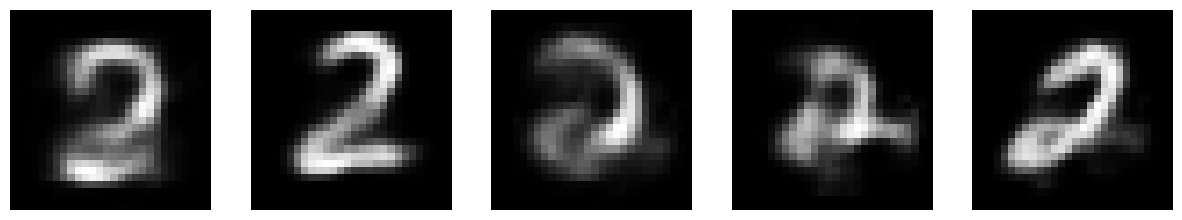

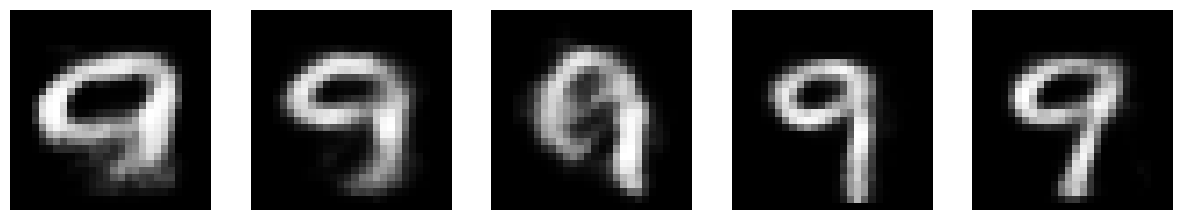

In [13]:
digits_to_generate = [4, 2, 9]
n_images_per_digit = 5

import matplotlib.pyplot as plt

for digit in digits_to_generate:
    generated_images = generate_images(conditional_model, digit, n_images_per_digit)
    fig, axes = plt.subplots(1, n_images_per_digit, figsize=(15, 3))
    for i, img in enumerate(generated_images):
        axes[i].imshow(img.squeeze(0), cmap='gray')
        axes[i].axis('off')
    plt.show()